In [26]:
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
import math

# 4. 多层感知机

- 过拟合(overfitting)

    过拟合表示模型的训练误差较小，而验证误差很大，说明模型在训练集表现比较好，但是泛化能力一般。
    
    发生过拟合后，可以通过降低模型复杂度来减轻过拟合，下面介绍两种常用的降低模型复杂度的方法。

    - 增加$L2$罚项，这种增加罚项的方法也叫做[岭回归](../SupervisedLearning/linear_regression.ipynb)。

    $$L(\mathbf{w})=f({\mathbf{w}})+\lambda||\mathbf{w}||^2\quad, \lambda \gt 0$$

    - 暂退法(dropout)

    暂退法是在训练时，隐藏层按照一定概率随机丢弃掉某些神经元的值，也就是将该神经元的值置0

    假设$h$是隐藏层某个神经元的输出，经过dropout后的值为$h'$，那么

    $$
    h'=\begin{cases}
    0 &, 概率p \\
    \frac{h}{1-p}&, otherwise
    \end{cases}$$

    因此$E(h')=0 \times p + \frac{h}{1-p} \times (1-p)=h$




## 课后习题
### 4.1 多层感知机

1. 计算pReLU激活函数的导数。

    $$
    \mathrm{pReLU}(x) = \mathrm{max}(0, x) + \alpha \mathrm{min}(0, x) \\
    \frac{\partial \mathrm{pReLU}(x)}{\partial x} = \begin{cases}
    1 &, x \gt 0 \\
    -\alpha &, x \lt 0
    \end{cases}
    $$

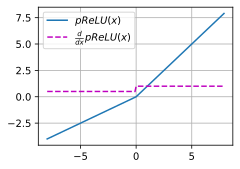

In [62]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.prelu(x, torch.tensor([0.5], dtype=torch.float32))
y.backward(torch.ones_like(x),retain_graph=True)
x_ = np.stack((x.detach(), x.detach()))
y_ = np.stack((y.detach(), x.grad.data.detach()))
d2l.plot(x_, y_, legend=["$pReLU(x)$", r"$\frac{d}{dx}pReLU(x)$"])

2. 证明一个仅使用ReLU（或pReLU）的多层感知机构造了一个连续的分段线性函数。

    假设$\boldsymbol{x}$是一个一维向量，并且隐藏层只有一个神经元$h_1$，那么

    $$\begin{aligned}
    o_1(x) &= w^{(2)}h_1 + b^{(2)} \\
    &= w^{(2)}\mathrm{max}(0, w^{(1)}x+b^{(1)}) + b^{(2)} \\
    \end{aligned}$$

    假设$w^{(1)} \gt 0$ 且 $x \lt t$有$h_1 \lt 0$，那么

    $$o_1(x)=\begin{cases}
    w^{(1)}w^{(2)}x+w^{(2)}b^{(1)}+b^{(2)} &, x \ge t \\
    b^{(2)}, &, x \lt t
    \end{cases}$$

    这意味$o_1$是一个分段线性函数，该结论也可以推广到$\boldsymbol{x}$是$d$维向量。

3. 证明$\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$。

    $$ \begin{aligned}
    \operatorname{tanh}(x) + 1 &= \frac{1 - \exp(-2x)}{1 + \exp(-2x)} + 1 \\
    &= \frac{2}{1 + \exp(-2x)} \\
    &= 2 \operatorname{sigmoid}(2x)
    \end{aligned}$$

### 4.2 多层感知机的从零开始实现

In [71]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):  #@save
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater, need_plot = True, animator=None):  #@save
    if need_plot:
        if not animator:
            animator = d2l.Animator(xlabel="epoch", xlim=[1, num_epochs], legend=["train loss", "train acc", "test acc"])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        if need_plot:
            animator.add(epoch+1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    return train_loss, train_acc, test_acc

1. 在所有其他参数保持不变的情况下，更改超参数num_hiddens的值，并查看此超参数的变化对结果有何影响。确定此超参数的最佳值。

    从下面可以看到当`num_hiddens`为256，测试集精度最高，再增加后模型开始出现过拟合现象。

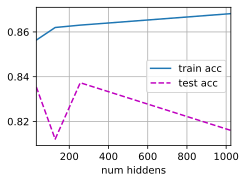

In [4]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)
    return (H@W2 + b2)

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
num_inputs, num_outputs= 784, 10
animator = d2l.Animator(xlabel="num hiddens", xlim=[32, 1024], legend=["train acc", "test acc"])

for num_hiddens in [32, 128, 256, 1024]:
    W1 = nn.Parameter(torch.randn(
        num_inputs, num_hiddens, requires_grad=True) * 0.01)
    b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
    W2 = nn.Parameter(torch.randn(
        num_hiddens, num_outputs, requires_grad=True) * 0.01)
    b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
    params = [W1, b1, W2, b2]
    loss = nn.CrossEntropyLoss(reduction='none')
    num_epochs, lr = 10, 0.1
    updater = torch.optim.SGD(params, lr=lr)
    _, train_acc, test_acc = train_ch3(net, train_iter, test_iter, loss, num_epochs, updater, False)
    animator.add(num_hiddens, [train_acc, test_acc])

2. 尝试添加更多的隐藏层，并查看它对结果有何影响。

    隐藏层大小固定为256，当隐藏层数为1时效果最好，再增加隐藏层，效果反而变差。

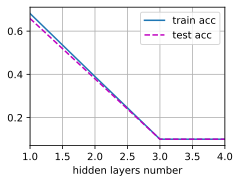

In [6]:
def get_hidden_layter_params(num_inputs, hidden_layer, num_outputs):
    print("hidden layer num:", len(hidden_layer))
    params = []
    prev = num_inputs
    for i, num_hiddens in enumerate(hidden_layer):
        W = nn.Parameter(torch.randn(
        prev, num_hiddens, requires_grad=True) * 0.01)
        b = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
        prev = num_hiddens
        params += [W, b]
    W = nn.Parameter(torch.randn(
        prev, num_outputs, requires_grad=True) * 0.01)
    b = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
    params += [W, b]
    print("params:", len(params))
    return params

animator = d2l.Animator(xlabel="hidden layers number", legend=["train acc", "test acc"], xlim=[1, 4])
for hidden_layer_num in range(4):
    params = get_hidden_layter_params(num_inputs, [256]*(hidden_layer_num+1), num_outputs)
    def net(X):
        X = X.reshape((-1, num_inputs))
        H = X
        for i in range(0, len(params), 2):
            w, b = params[i], params[i+1]
            assert H.shape[-1] == w.shape[0], f"{H.shape}, {w.shape}"
            H = relu(H@w+b)
        return H
    loss = nn.CrossEntropyLoss(reduction='none')
    num_epochs, lr = 10, 0.1
    updater = torch.optim.SGD(params, lr=lr)
    _, train_acc, test_acc = train_ch3(net, train_iter, test_iter, loss, num_epochs, updater, False)
    animator.add(hidden_layer_num+1, [train_acc, test_acc])

3. 改变学习速率会如何影响结果？保持模型架构和其他超参数（包括轮数）不变，学习率设置为多少会带来最好的结果？

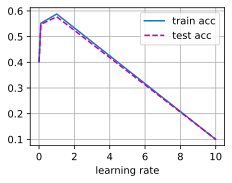

In [7]:
params = get_hidden_layter_params(num_inputs, [256], num_outputs)
lr_list = [0.001, 0.1, 1, 10]
animator = d2l.Animator(xlabel="learning rate", legend=["train acc", "test acc"])
for lr in lr_list:
    updater = torch.optim.SGD(params, lr=lr)
    _, train_acc, test_acc = train_ch3(net, train_iter, test_iter, loss, num_epochs, updater, False)
    animator.add(lr, [train_acc, test_acc])

5. 描述为什么涉及多个超参数更具挑战性。

    参数数量较多，那么参数空间就比较大，想寻找最优参数就更有挑战性。

### 4.3 多层感知机的简洁实现

In [22]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
def init_net(hidden_layers, num_inputs, num_outputs, active_func=nn.ReLU, init_weights=init_weights):
    net = nn.Sequential(nn.Flatten())
    prev = num_inputs
    for i in hidden_layers:
        net.append(nn.Linear(prev, i))
        net.append(active_func())
        prev = i
    net.append(nn.Linear(prev, num_outputs))
    net.apply(init_weights)
    return net

1. 尝试添加不同数量的隐藏层（也可以修改学习率），怎么样设置效果最好？

    2层隐藏层数量时，测试集精度最高，由于参数初始化服从正态分布，因此结果可能和上面手动实现跑出来有差异。

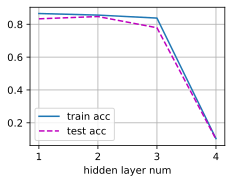

In [9]:
animator = d2l.Animator(xlabel="hidden layer num", legend=["train acc", "test acc"])
for i in range(4):
    net = init_net([256]*(i+1), num_inputs, num_outputs)
    trainer = torch.optim.SGD(net.parameters(), lr=0.1)
    _, train_acc, test_acc = train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer, False)
    animator.add(i+1, [train_acc, test_acc])

2. 尝试不同的激活函数，哪个效果最好？

    貌似差别不大

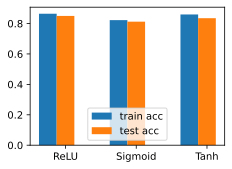

In [20]:
data = {"train acc": [], "test acc": []}
active_func_name = []
train_iter, test_iter = d2l.load_data_fashion_mnist(256)
for active_func in [nn.ReLU, nn.Sigmoid, nn.Tanh]:
    net = init_net([256], num_inputs, num_outputs, active_func)
    trainer = torch.optim.SGD(net.parameters(), lr=0.1)
    _, train_acc, test_acc = train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer, False)
    data["train acc"].append(train_acc), data["test acc"].append(test_acc)
    active_func_name.append(active_func.__name__)
ax = d2l.plt.subplot()
x = np.arange(len(active_func_name))
idx = 0
for attr, acc in data.items():
    off = 0.25 * idx
    ax.bar(x+off, acc, 0.25, label=attr)
    idx += 1
ax.set_xticks(x + 0.25, active_func_name)
ax.legend()
d2l.plt.show()

3. 尝试不同的方案来初始化权重，什么方法效果最好？

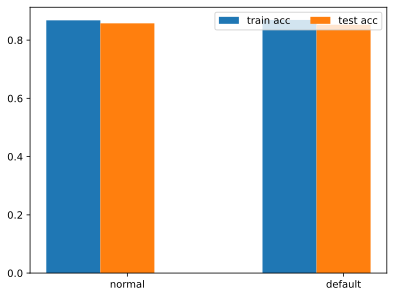

In [25]:
init_weights_list = [init_weights, lambda x: x]
data = {"train acc": [], "test acc": []}
x_name = ["normal", "default"]
train_iter, test_iter = d2l.load_data_fashion_mnist(256)
for init_weights in init_weights_list:
    net = init_net([256], num_inputs, num_outputs, init_weights=init_weights)
    trainer = torch.optim.SGD(net.parameters(), lr=0.1)
    _, train_acc, test_acc = train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer, False)
    data["train acc"].append(train_acc), data["test acc"].append(test_acc)
ax = d2l.plt.subplot()
x = np.arange(len(x_name))
idx = 0
for attr, acc in data.items():
    off = 0.25 * idx
    ax.bar(x+off, acc, 0.25, label=attr)
    idx += 1
ax.set_xticks(x + 0.25, x_name)
ax.legend(ncols=2)
d2l.plt.show()

### 4.4 模型选择、欠拟合和过拟合

In [35]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400, need_plot = True):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    if need_plot:
        animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if (epoch == 0 or (epoch + 1) % 20 == 0) and need_plot:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())
    return evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)

1. 这个多项式回归问题可以准确地解出吗？提示：使用线性代数。

    令
    $$
    \mathbf{w}=\begin{bmatrix}
    w_0 \\
    \vdots \\
    w_m
    \end{bmatrix}\quad, \mathbf{x}_i=\begin{bmatrix}
    x_i^0 \\
    \vdots \\
    x_i^m
    \end{bmatrix}\quad, \mathbf{X}=\begin{bmatrix}
    x_0^0& \cdots& x_0^m \\
    \vdots& \vdots& \vdots \\
    x_n^0& \cdots& x_n^m
    \end{bmatrix} = \begin{bmatrix}
    \mathbf{x}_0^\top \\
    \vdots \\
    \mathbf{x}_n^\top
    \end{bmatrix}\quad, \mathbf{y}=\begin{bmatrix}
    y_1 \\
    \vdots \\
    y_n
    \end{bmatrix}
    $$

    那么总的损失为

    $$\begin{aligned}
    L(\mathbf{w}) &= \frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(\sum_{j=0}^{m}w_j x_i^j-y_i)^2 \\
    &= \frac{1}{2n}(\mathbf{w}^\top\mathbf{X}^\top-\mathbf{y}^\top)(\mathbf{w}^\top\mathbf{X}^\top-\mathbf{y}^\top)^\top
    \end{aligned}$$

    对$\mathbf{w}$求导有

    $$\begin{aligned}
    \frac{d}{d \mathbf{w}}L(\mathbf{w}) &= \frac{1}{n}\mathbf{X}^\top\mathbf{X}\mathbf{w}-\frac{1}{n}\mathbf{X}^\top\mathbf{y}
    \end{aligned}$$
    
    因此
    
    $$\mathbf{w}^*=(\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}\mathbf{y}$$

2. 考虑多项式的模型选择。
    - 绘制训练损失与模型复杂度（多项式的阶数）的关系图。观察到了什么？需要多少阶的多项式才能将训练损失减少到0?
    - 在这种情况下绘制测试的损失图。
    - 生成同样的图，作为数据量的函数。

    

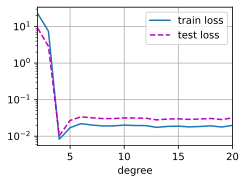

In [42]:
animator = d2l.Animator(xlabel="degree", yscale="log", xlim=[2, 20], legend=["train loss", "test loss"])
for d in range(2, 21):
    train_loss, test_loss = train(poly_features[:n_train, :d], poly_features[n_train:, :d],
      labels[:n_train], labels[n_train:], need_plot=False)
    animator.add(d, [train_loss, test_loss])

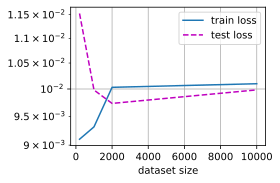

In [50]:
def generate_data(n_train, n_test):
    features = np.random.normal(size=(n_train + n_test, 1))
    np.random.shuffle(features)
    poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
    for i in range(max_degree):
        poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
    labels = np.dot(poly_features, true_w)
    labels += np.random.normal(scale=0.1, size=labels.shape)
    features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [features, poly_features, labels]]
    return features, poly_features, labels

dataset_size = [200, 1000, 2000, 10000]
animator = d2l.Animator(xlabel="dataset size", yscale="log", legend=["train loss", "test loss"])
for s in dataset_size:
    n_train, n_test = int(s/2), int(s/2)
    features, poly_features, labels = generate_data(n_train, n_test)
    train_loss, test_loss = train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:], need_plot=False)
    animator.add(s, [train_loss, test_loss])

3. 如果不对多项式特征$x_i$进行标准化($1/i!$)，会发生什么事情？能用其他方法解决这个问题吗？

    避免出现较大的梯度或者损失值导致溢出，还有一种方法是每个特征都减去平均值$\mu$并除以标准差$\sigma$

### 4.5 权重衰减

In [55]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

def train_concise(wd, need_plot=True):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    if need_plot:
        animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0 and need_plot:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())
    return d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)

1. 在本节的估计问题中使用$\lambda$的值进行实验。绘制训练和测试精度关于$\lambda$的函数。观察到了什么？

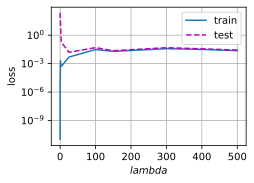

In [61]:
wd_list = [0, 0.01, 0.1, 1, 3, 25, 100, 150, 300, 400, 500]
animator = d2l.Animator(xlabel='$lambda$', ylabel='loss', yscale='log', legend=['train', 'test'])
for wd in wd_list:
    train_loss, test_loss = train_concise(wd, need_plot=False)
    animator.add(wd, [train_loss, test_loss])

3. 如果我们使用$\sum_i|w_i|$作为我们选择的惩罚（$L_1$正则化），那么更新方程会是什么样子？

    $$ \mathbf{w} \leftarrow \mathbf{w} - \lambda sign(\mathbf{w})+\frac{\eta}{n}\sum_{i=1}^{n}\mathbf{x}^{(i)}(\mathbf{w}^\top\mathbf{x}^{(i)}+b-y^{(i)})$$

### 4.6 暂退法(Dropout)

In [69]:
def init_net_with_dropout(num_inputs, num_outputs, hidden_layer, dropout, init_weights_fn=None):
    net = nn.Sequential(nn.Flatten())
    prev = num_inputs
    for num_hiddens, dropout_p in zip(hidden_layer, dropout):
        net.append(nn.Linear(prev, num_hiddens))
        net.append(nn.ReLU())
        net.append(nn.Dropout(dropout_p))
        prev = num_hiddens
    net.append(nn.Linear(prev, num_outputs))
    if not init_weights_fn:
        init_weights_fn = init_weights
    net.apply(init_weights_fn)
    return net

1. 如果更改第一层和第二层的暂退法概率，会发生什么情况？具体地说，如果交换这两个层，会发生什么情况？设计一个实验来回答这些问题，定量描述该结果，并总结定性的结论。

    如下，交换两层的暂退法概率，当越低的隐藏层概率越大时，那么训练误差也会越大。

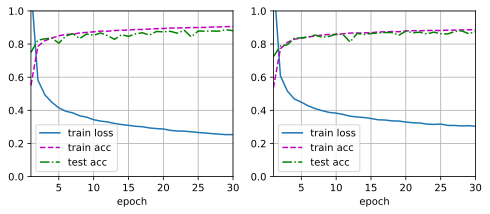

In [83]:
num_epochs, lr, batch_size = 30, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
animator = d2l.Animator(xlabel="epoch", xlim=[1, num_epochs], ylim=[0, 1], 
                        legend=["train loss", "train acc", "test acc"], 
                        nrows=1, ncols=2, figsize=(8, 3))
num_inputs, num_outputs = 784, 10
titles = [r"dropout=[0.2, 0.5]", r"dropout=[0.5, 0.2]"]
for i, dropout in enumerate([[0.2, 0.5], [0.5, 0.2]]):
    net = init_net_with_dropout(num_inputs, num_outputs, [256, 256], dropout)
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    animator.axes[0] = animator.axes[i]
    animator.axes[0].set_title(titles[i])
    animator.X = None
    animator.Y = None
    train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer, animator=animator)

2. 增加训练轮数，并将使用暂退法和不使用暂退法时获得的结果进行比较。

    随着epoch增加，不使用暂退法训练出来的模型训练误差减少的更多，但是训练精度和测试精度的差值变大，这是过拟合现象，因此使用暂退法减少过拟合问题。

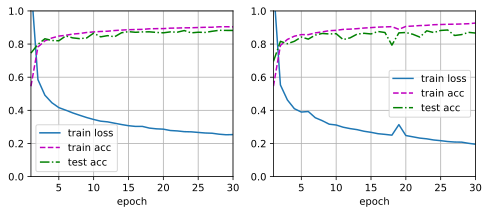

In [88]:
animator = d2l.Animator(xlabel="epoch", xlim=[1, num_epochs], ylim=[0, 1], 
                        legend=["train loss", "train acc", "test acc"], 
                        nrows=1, ncols=2, figsize=(8, 3))
nets = [init_net_with_dropout(num_inputs, num_outputs, [256, 256], [0.2, 0.5]), init_net([256, 256], num_inputs, num_outputs)]
titles = ["dropout", "No dropout"]
for i, net in enumerate(nets):
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    animator.axes[0] = animator.axes[i]
    animator.axes[0].set_title(titles[i])
    animator.X = None
    animator.Y = None
    train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer, animator=animator)

4. 为什么在测试时通常不使用暂退法？

    暂退法是为了在训练时调整参数避免模型过拟合，推理时模型参数已经确定，不需要更新参数，因此不需要使用暂退法，同时如果在推理时使用暂退法，结果具有随机性。

5. 以本节中的模型为例，比较使用暂退法和权重衰减的效果。如果同时使用暂退法和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？

    图三是加了dropout和权重衰减，和图二只有权重衰减效果差不多，因此结果不是累加的。和图四既没有dropout也没有权重衰减相比，loss下降的不明显，收益不大。

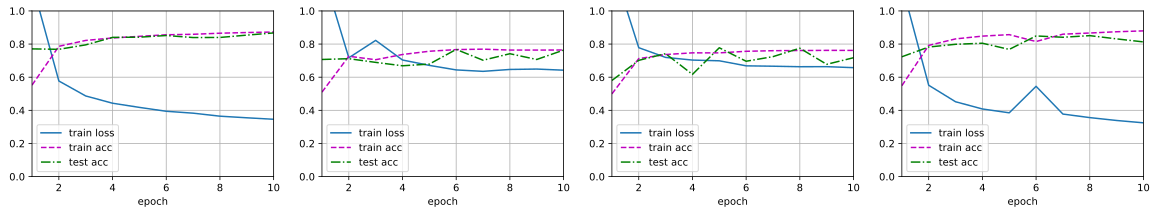

In [99]:
nets = [init_net_with_dropout(num_inputs, num_outputs, [256, 256], [0.2, 0.5]), 
        init_net([256, 256], num_inputs, num_outputs),
        init_net_with_dropout(num_inputs, num_outputs, [256, 256], [0.2, 0.5]),
        init_net([256, 256], num_inputs, num_outputs)]
def get_trainer(net, lr, **kwargs):
    return torch.optim.SGD(net.parameters(), lr=lr)
def get_trainer_with_weight_decay(net: nn.Module, lr, **kwargs):
    params = []
    wd = kwargs.pop("weight_decay") if "weight_decay" in kwargs else 0.01
    for module in net.modules():
        if isinstance(module, nn.Linear):
            params.append({"params":module.weight,'weight_decay': wd})
            params.append({"params":module.bias})
    return torch.optim.SGD(params, lr=lr)
num_epochs = 10
animator = d2l.Animator(xlabel="epoch", xlim=[1, num_epochs], ylim=[0, 1], 
                        legend=["train loss", "train acc", "test acc"], 
                        nrows=1, ncols=4, figsize=(20, 3))
titles = ["dropout", "weight decay", "dropout and weight decay", "nothing"]
for i, net, trainer_fn in zip(range(4), nets, [get_trainer, get_trainer_with_weight_decay, get_trainer_with_weight_decay, get_trainer]):
    animator.axes[0] = animator.axes[i]
    animator.axes[0].set_title(titles[i])
    animator.X, animator.Y = None, None
    train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer_fn(net, lr), animator=animator)